## Imports

In [358]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import quotes_by_gender, unique_speaker_per_gender, get_champlex
from collections import Counter
import math
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx

## Dataset


In [359]:
DATA_FOLDER = 'data/'
QUOTES_DATA = DATA_FOLDER + 'data_observational.json.bz2'

## Dictionnaries

In [360]:
DICTIONNARY_FOLDER = DATA_FOLDER + 'dictionnaries/'
DICT_OCCUPATIONS = DICTIONNARY_FOLDER + 'occupations_categories.json'
DICT_DEGREES = DICTIONNARY_FOLDER + 'degrees_categories.json'

## Attributes

In [361]:
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

In [362]:
attributes = pd.read_parquet(SPEAKER_ATTRIBUTES_DATA)

## Load the data

In [363]:
quotes = pd.read_json(QUOTES_DATA)

In [364]:
with open(DICT_OCCUPATIONS) as f:
    dict_occupations = json.load(f)

In [365]:
with open(DICT_DEGREES) as f:
    dict_degrees = json.load(f)

# Some preprocessing again

In [367]:
def translate(my_list, my_dict):
    """Allows to transform a list of items into a list of corresponding categories. 
    The list returned contains uniques category (the duplicates are removed).
    
    Parameters
    ----------
    my_list: the list to be translated
    my_dict: the dictionnary according which we want to translate the list
    
    Returns
    --------
    list of uniques categories"""
    translated_list = []
    for i in my_list:
        if i in my_dict.keys():
            translated_list.append(my_dict[i])
        else:
            translated_list.append('Others')
    #Drop duplicates
    return (list(set(translated_list)))
    
        

Now, we replace the occupations and academic degrees by more general categories

In [368]:
quotes['occupation'] = quotes['occupation'].apply(lambda x: translate(x, dict_occupations))

In [369]:
quotes['academic_degree'] = quotes['academic_degree'].apply(lambda x: translate(x, dict_degrees))

Separate the dataframe into two that we will analyze separatly: the male speakers vs the female speakers.

In [370]:
quotes_males = quotes[quotes['gender'] == 'male']
quotes_females = quotes[quotes['gender'] == 'female']

## Preparation of the dataframe for the propensity score calculation: on commence par les femmes

Now, we want to calculate the propensity scores of each speaker. To do that, we need to group the quotations by speakers, and to recover some information about them.

In [371]:
print('Our dataset contains', quotes_females.shape[0], 'quotes from female speakers.')

Our dataset contains 306229 quotes from female speakers.


We group by qids and label: grouping by qids avoid to dintguish the same person in two because of different alisases. We group also by label because we want to separate women before and after the movement: if a woman talks before and after, we consider her as "2 women".

In [372]:
grouped_females = quotes_females.groupby(['qids', 'label'])

After having grouped the quotations per speaker, we take the attributes corresponding to the first quotation: these attributes are immutable (the academic degree, the occupation, the speaker name and the gender), thus we can recover it from the first quotation.

In [374]:
attributes_immutable = grouped_females.first().reset_index().drop(['year', 
                                                                   'quotation', 'numOccurrences', 'age'], axis = 1)
attributes_immutable

,qids,label,speaker,gender,occupation,academic_degree
0,Q101160,1,Gesche Joost,female,"[Teaching, Government]",[doctor]
1,Q101496,0,Michaela Haas,female,"[Entertainment, Journalism]",[doctor]
2,Q102430,0,Sonia Mikich,female,"[Entertainment, Journalism]",[master]
3,Q102488,0,Juliane Wetzel,female,[Historian],[doctor]
4,Q102488,1,Juliane Wetzel,female,[Historian],[doctor]
...,...,...,...,...,...,...
1980,Q98885,1,Maike Kohl-Richter,female,"[Social Sciences, Journalism, Writer]",[doctor]
1981,Q99306,1,Nermin Abadan Unat,female,"[Social Sciences, Teaching, Law]",[doctor]
1982,Q99590,1,Rebekka Habermas,female,"[Teaching, Historian]",[doctor]
1983,Q996967,0,Diane Coyle,female,"[Social Sciences, Teaching, Journalism]",[doctor]


Now we will calculate the number of quotes per speaker, as well as the number of occurrences per speaker. We also put the age of the speaker to the median age of all its quotations. 

In [376]:
#Get the number of unique quotes per speaker
quotations_per_speaker = grouped_females['quotation'].count().reset_index(name='nb_quotes')

#Get the number of total occurrences of the speaker
occurrences_per_speaker = grouped_females['numOccurrences'].sum().reset_index(name='nb_occurrences')

#Get the median age of the speaker if she talks many times
age_per_speaker = grouped_females['age'].median().reset_index(name='age')

In [377]:
attributes_mutable = pd.merge(pd.merge(quotations_per_speaker, occurrences_per_speaker, on = ['qids', 'label']), 
                              age_per_speaker, on = ['qids', 'label'])

In [378]:
attributes_mutable.head()

,qids,label,nb_quotes,nb_occurrences,age
0,Q101160,1,4,4,44.0
1,Q101496,0,12,25,46.0
2,Q102430,0,8,8,66.0
3,Q102488,0,1,1,60.0
4,Q102488,1,10,62,61.0


In [379]:
data_per_speaker = pd.merge(attributes_immutable, attributes_mutable, on = ['qids', 'label'])

In [380]:
data_per_speaker.head()

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age
0,Q101160,1,Gesche Joost,female,"[Teaching, Government]",[doctor],4,4,44.0
1,Q101496,0,Michaela Haas,female,"[Entertainment, Journalism]",[doctor],12,25,46.0
2,Q102430,0,Sonia Mikich,female,"[Entertainment, Journalism]",[master],8,8,66.0
3,Q102488,0,Juliane Wetzel,female,[Historian],[doctor],1,1,60.0
4,Q102488,1,Juliane Wetzel,female,[Historian],[doctor],10,62,61.0


One-hot encoding for the logistic regression:

In [381]:
dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)

/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_1756/3314558053.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_1756/3314558053.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)


In [382]:
##C'est sombre mais get_dummies cree une colomn 'Others' donc en attendant de comprendre pq:
dummies_occ.drop(['Others'], axis = 1, inplace = True)
dummies_degree.drop(['Others'], axis = 1, inplace = True)

In [383]:
#Parce que la regression aime pas les espaces dans les noms de variables
dummies_occ.columns = dummies_occ.columns.str.replace(" ", "_")
dummies_degree.columns = dummies_degree.columns.str.replace(" ", "_")

In [384]:
data_features = pd.merge(pd.merge(data_per_speaker, dummies_occ, left_index = True, right_index = True), dummies_degree, left_index = True, right_index = True)


Before calculating the propensity scores, we should standardize the continuous features. Let's look at their distributions in order to choose an appropriate standardization. 

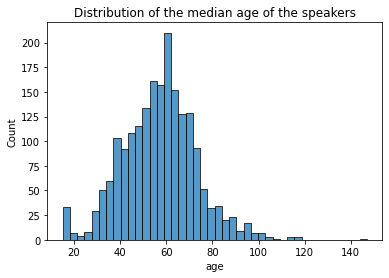

In [385]:
ax = sns.histplot(data_features['age'])
ax.set_title("Distribution of the median age of the speakers");

The distribution of the age seems to follow a gaussian distribution, thus, we will standardize it.

In [386]:
data_features['age'] = (data_features['age'] - data_features['age'].mean())/data_features['age'].std()

## Propensity scores calculation

In [387]:
occupations_for_regression = ['C('+ str(x)+ ')' for x in dummies_occ.columns.tolist()]

In [388]:
degrees_for_regression = ['C('+ str(x)+ ')' for x in dummies_degree.columns.tolist()]

In [389]:
def create_formula_from_list_categories(my_list):
    list_for_regression = ['C('+ str(x)+ ')' for x in my_list]
    formula = ''
    for i in list_for_regression:
        formula += i
        if i != list_for_regression[-1]:
            formula += ' + '
    return formula
    

In [390]:
formula_occupations = create_formula_from_list_categories(dummies_occ.columns.tolist())

In [391]:
formula_degrees = create_formula_from_list_categories(dummies_degree.columns.tolist())

In [392]:
mod = smf.logit(formula='label ~  age + ' + formula_occupations + ' + ' + formula_degrees, data=data_features)

res = mod.fit()

# Extract the estimated propensity scores
data_features['Propensity_score'] = res.predict()

print(res.summary())

         Current function value: 0.687871
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 1985
Model:                          Logit   Df Residuals:                     1934
Method:                           MLE   Df Model:                           50
Date:                Mon, 29 Nov 2021   Pseudo R-squ.:                0.007547
Time:                        19:48:54   Log-Likelihood:                -1365.4
converged:                      False   LL-Null:                       -1375.8
Covariance Type:            nonrobust   LLR p-value:                    0.9999
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0963      0.178      0.540      0.589      -0.253       0.445
C(Activist)

/Users/lisa/opt/anaconda3/envs/ada/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [393]:
data_features.head(2)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,bachelor,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,Propensity_score
0,Q101160,1,Gesche Joost,female,"[Teaching, Government]",[doctor],4,4,-0.813569,0,...,0,0,0,1,0,0,0,0,0,0.448203
1,Q101496,0,Michaela Haas,female,"[Entertainment, Journalism]",[doctor],12,25,-0.688494,0,...,0,0,0,1,0,0,0,0,0,0.514804


In [394]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [324]:
# Separate the treatment and control groups
treatment_df = data_features[data_features['label'] == 1]
control_df = data_features[data_features['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

Create our balanced dataset:

In [395]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [396]:
balanced_df_females = data_features.iloc[matched]

In [397]:
balanced_df_females.head()

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,bachelor,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,Propensity_score
1592,Q5297690,1,Doreen Virtue,female,"[Communication, Writer]",[doctor],33,39,0.187029,0,...,0,0,0,1,0,0,0,0,0,0.450254
1736,Q6153626,1,Janet Thornton,female,[Scientist],[doctor],3,3,0.749866,0,...,0,0,0,1,0,0,0,0,0,0.534279
648,Q22341204,0,Nozipho Mxakato-Diseko,female,[Government],[doctor],92,869,0.124492,0,...,0,0,0,1,0,0,0,0,0,0.502655
344,Q16979968,0,Jenny Nelson,female,[Scientist],[doctor],28,32,-2.595885,0,...,0,0,0,1,0,0,0,0,0,0.419661
1618,Q5407905,0,Eugenia Kalnay,female,[Scientist],[doctor],5,10,1.000016,0,...,0,0,0,1,0,0,0,0,0,0.542853


In [398]:
##Pour éviter de run again le matching j'ai sauvegardé le resultat
balanced_df_females.to_json(DATA_FOLDER + 'results/balanced_dataset_female.json.bz2')

In [406]:
#J'ai sauvegardé aussi les paires
textfile = open("matching.txt", "w")
for element in matching:
    textfile.write(str(element) + "\n")
textfile.close()

Let's check the size of our dataset

In [399]:
print('We have', balanced_df_females[balanced_df_females['label'] == 0].shape[0], 'speakers before #MeToo')
print('We have', balanced_df_females[balanced_df_females['label'] == 0].shape[1], 'speakers after #MeToo')
print('The data are balanced now!')

We have 983 speakers before #MeToo
We have 59 speakers after #MeToo
The data are balanced now!


# A checker au moment d'analyser les outcomes: je crois que nb_occurences et nb_quotes sont des heavy tailed distributions! Voir comment on peut les analyser.

In [203]:
data_features['nb_occurrences'].describe()

count      1985.000000
mean        904.423678
std        9029.809671
min           1.000000
25%           4.000000
50%          16.000000
75%          87.000000
max      274275.000000
Name: nb_occurrences, dtype: float64

In [240]:
data_features[data_features['qids'] == 'Q6294']

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,aggregation,bachelor,candidate,certificate,doctor,high school diploma,master,non specified degree,not classified,professor
1745,Q6294,0,Hillary Clinton,female,"[Government, Journalism, Writer, Law, Teaching]","[bachelor, doctor]",41261,274275,0.749866,0,...,0,1,0,0,1,0,0,0,0,0
1746,Q6294,1,Hillary Clinton,female,"[Government, Journalism, Writer, Law, Teaching]","[bachelor, doctor]",11137,60926,0.874941,0,...,0,1,0,0,1,0,0,0,0,0


Hillary Clinton a 274275 citations avant #MeToo. Seulement 60926 après (du aux éléctions).